(506, 13) (506, 1)
110.58049674804326 168.33876505085956


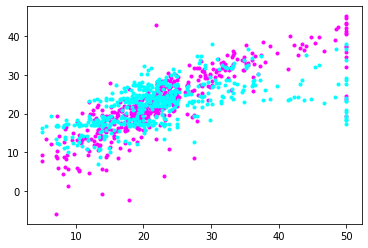

In [1]:
# 1, Regression with Linear and Radial Basis Function Models

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
rawData = np.genfromtxt('C:\\Users\\zhoujie\\Desktop\\housing.data')
N, pp1 = rawData.shape

# Last column is target
X = np.matrix(rawData[:,0:pp1-1])
y = np.matrix(rawData[:,pp1-1]).T
print(X.shape, y.shape)

# Solve linear regression, plot target and prediction
w = (np.linalg.inv(X.T*X)) * X.T * y
yh_lin = X*w
plt.plot(y, yh_lin, '.', Color='magenta')

# J = 20basis functions obtained by k-means clustering
# sigma set to standard deviation of entire data
from sklearn.cluster import KMeans

J = 20;
kmeans = KMeans(n_clusters=J,random_state=0).fit(X)
sig=np.std(X)

#Construct design matrix
U=np.zeros((N,J))
for i in range(N):
    for j in range(J):
        #U[i][j]=np.linalg.norm(X[i]-kmeans.cluster_centers_[j])
        U[i][j]=np.exp(-(np.linalg.norm(X[i]-kmeans.cluster_centers_[j]) / sig)**2)
        

#Solve RBF model, predict and plot
w=np.dot((np.linalg.inv(np.dot(U.T,U))), U.T) * y
yh_rbf = np.dot(U,w)
plt.plot(y, yh_rbf, '.', Color='cyan')
print(np.linalg.norm(y-yh_lin), np.linalg.norm(y-yh_rbf))

524.6168785828486
172.62678064635136


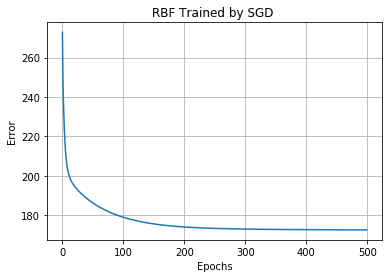

In [3]:
#initialized w
w0 = np.random.randn(J,1)
#error
E0 = np.linalg.norm(y - U @ w0)
print(E0)


epochs = 500
lRate = 0.001
Eplot = np.zeros((epochs, 1))
wIter= w0
y=np.asarray(y)
for epoch in range(epochs):
    for j in range(U.shape[0]):
        xj = np.array([U[j,:]]).T
        yj = y[j,:]
        yPred = xj.T @ wIter
        wIter = wIter - lRate * (yPred - yj) * xj   
    Eplot[epoch] = np.linalg.norm(y - U @ wIter)
print(np.linalg.norm(y - U @ wIter))
fig, ax = plt.subplots()
ax.plot(Eplot)
ax.set_xlabel("Epochs")
ax.set_ylabel("Error")
ax.grid(True)
ax.set_title("RBF Trained by SGD ")
plt.savefig('C:\\Users\\zhoujie\\Desktop\\RBF Trained by SGD.png')

In [3]:
''' 
2, Mountain Car Control Problem, Discrete States
https://github.com/openai/gym/wiki/MountainCar-v0

I   Tabular Solution Methods:
Q-learning (off-policy TD control) for estimating π≈π* ---P131 Reinforcement Learning Richard S. Sutton and Andrew G. Barto

'''
import gym
import numpy as np
env_name = "MountainCar-v0"
env = gym.make(env_name)

# This is just an implementation of the classic “agent-environment loop”. 
# Each timestep, the agent chooses an action, and the environment returns an observation and a reward.
# The process gets started by calling reset(), which returns an initial observation 

obs = env.reset() 
env.render()

# Some initializations
#
n_states = 40
episodes = 10
initial_lr = 1.0
min_lr = 0.005
gamma = 0.99
max_stps = 300
epsilon = 0.05
env = env.unwrapped # https://stackoverflow.com/questions/53836136/why-unwrap-an-openai-gym 
env.seed()
np.random.seed(0)


# Quantize the states
#
def discretization(env, obs):
    env_low = env.observation_space.low # the lower bound of position: -1.2,and velocity:-0.07
    env_high = env.observation_space.high # the upper bound of position: 0.6,and velocity:0.07
    env_den = (env_high - env_low)/n_states # the density of one state=[0.045, 0.0035]=[0.6-(-1.2), 0.07-(-0.07)]/40(# of states)
    pos_den = env_den[0]
    vel_den = env_den[1]
    
    pos_high = env_high[0]
    pos_low=env_low[0]
    vel_high=env_high[1]
    vel_low=env_low[1]
    
    pos_scaled=int((obs[0]-pos_low)/pos_den) # discretize the postion value as int in the state space
    vel_scaled=int((obs[1]-vel_low)/vel_den) # discretize the velocity value as int in the state space 
    return pos_scaled,vel_scaled
#env.action_space.n =# of actions=3(push left,no push,and push right)
q_table=np.zeros((n_states,n_states,env.action_space.n))
total_steps=0

for episode in range(episodes):
    print("Episode:",episode)
    obs=env.reset() # initialize state S
    total_reward=0
    alpha=max(min_lr,initial_lr*(gamma**(episode//100))) #constant step-size
    steps=0
    while True:
        env.render()
        pos, vel = discretization(env, obs) # discretize the current state
        if np.random.uniform(low=0, high=1) < epsilon:# Ɛ-greedy method: select a random action 'a' with probability Ɛ
            a = np.random.choice(env.action_space.n) 
        else:
            a = np.argmax(q_table[pos][vel])# otherwise take the greeedy action
        #Take action 'a', return next state, reward, whether episode terminate, and debugging info . 
        #The next state is stored in obs, can be discretized into pos,vel in the beginning of the loop 
        #and pos_,vel_ in the following statement
        obs, reward, terminate,_ = env.step(a)  
        total_reward += abs(obs[0]+0.5) #???
        pos_, vel_ = discretization(env, obs) #discretize the next state
        # Q function update:Q(S,A) ←Q(S,A) + α[R + γmaxQ(S',A')-Q(S,A)]=[1-α]Q(S,A) + α[R + γmaxQ(S',A')] 
        q_table[pos][vel][a] = (1-alpha)*q_table[pos][vel][a] + alpha*(reward+gamma*np.max(q_table[pos_][vel_]))
        steps += 1
        
        
        if terminate: # If terminate, Go to next episode
            break
# while True:
#     env.render()

Episode: 0
Episode: 1
Episode: 2
Episode: 3
Episode: 4
Episode: 5
Episode: 6
Episode: 7
Episode: 8
Episode: 9
